# Sommaire

* [Importation des données](#import)
* [Détermination de cluster par la méthode KMeans](#kmeans)
* [Scaling des données (avec Robust Scaler)](#scaling)
* [Création du modèle avec KNN](#knn)
* [Test avec dataset nettoyé](#cleaned)
* [Exportation du modèle avec pickle](#scaling)

In [95]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve

from sklearn.model_selection import learning_curve

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.inspection import permutation_importance
import seaborn as sns
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
from sklearn.preprocessing import RobustScaler

## Importation des données <a class="anchor" id="import"></a> 

Nous importons les valeurs que nous venons de nettoyer

In [82]:
df = pd.read_csv("C:/Users/Simplon/Desktop/California Dreamin/estate.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ISLAND,NEAR OCEAN,NEAR BAY,<1H OCEAN,INLAND
0,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,0,0,0,0,1
1,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,0,0,0,1,0
2,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,0,0,0,0,1
3,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,0,0,0,1,0
4,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16331,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0,0,0,0,0,1
16332,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0,0,0,1,0,0
16333,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0,0,0,0,0,1
16334,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0,0,0,0,1,0


## Détermination de cluster par la méthode KMeans <a class="anchor" id="kmeans"></a>

Pour améliorer notre modèle, avant d'appliquer tout changement nous allons appliquer la méthode KMeans afin de placer nos données dans des clusters. Cela nous permettra d'avoir accès à une nouvelle feature "cluster" qui sera très correllé. Donc utile pour la réalisation du modèle.

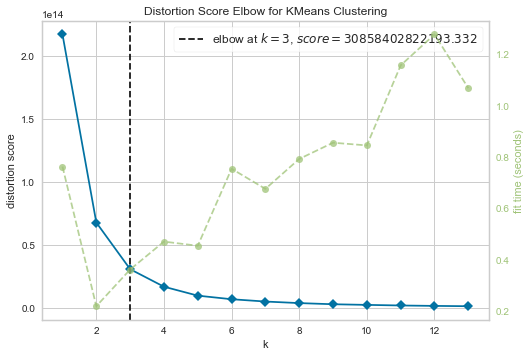

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
model = KMeans(random_state=50)
visualizer = KElbowVisualizer(model, k =(1,14))
visualizer.fit(df)
visualizer.show()

In [84]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [85]:
y_predicted=km.fit_predict(df)

In [86]:
df['cluster']=km.fit_predict(df)

### Preuve que le KMeans est utile 

Nous allons juste vérifier que la nouvelle features "cluster" est importante.

In [87]:
realcorr=df.corr()

In [88]:
corr_df = realcorr.unstack().reset_index() 
corr_df.columns = ['feature_1','feature_2', 'correlation'] 
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

In [89]:
corr_df = corr_df[corr_df['feature_1'] == 'median_house_value']
corr_df=(corr_df.reset_index(drop=True))
corr_df

,feature_1,feature_2,correlation
0,median_house_value,median_income,0.689593
1,median_house_value,<1H OCEAN,0.259971
2,median_house_value,NEAR BAY,0.160470
3,median_house_value,NEAR OCEAN,0.140880
4,median_house_value,total_rooms,0.132570
5,median_house_value,housing_median_age,0.109763
6,median_house_value,households,0.062674
7,median_house_value,total_bedrooms,0.047478
8,median_house_value,ISLAND,0.026780
9,median_house_value,population,-0.028033


Nous voyons donc la feature "cluster" qui a un score très important. L'opération est donc pertinente.

## Scaling des données (avec Robust Scaler) <a class="anchor" id="scaling"></a>

Scaler les données nous permettra de toutes les avoir au même niveau. Nous ne touchons cependant pas à la target (ici "median_house_value").

In [90]:
X = df.drop(columns=['median_house_value'],axis=1)
y = df['median_house_value']

In [91]:
rs=RobustScaler()
x=rs.fit_transform(X)

## Création du modèle avec KNN <a class="anchor" id="knn"></a>

Enfin, nous allons créer le modèle avec la méthode KNN

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)

In [67]:
knn = KNeighborsRegressor(n_neighbors=9)

In [68]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [69]:
pred = knn.predict(X_test)
pred

array([408522.44444444, 107622.22222222, 175188.88888889, ...,
       128355.55555556, 117755.55555556, 406622.55555556])

In [70]:
knn.score(X_test, y_test)

0.8960540200949887

#### Nous avons un score de 0,896. Il peut être amélioré en enlevant des features qui n'importe peu, sélectionné grâce à l'EDA. 

## Test avec dataset nettoyé <a class="anchor" id="cleaned"></a>

### Colonne à enlever  

Après plusieurs tests, les features suivantes sont enlevé : housing_median_age , ISLAND, total_rooms

Le score n'est que très peu enlevé, mais cela permet tout de même d'avoir un meilleur score.

In [72]:
ndf = df.drop(columns=['housing_median_age','ISLAND','total_rooms'],axis=1) 

In [74]:
X2 = ndf.drop(columns=['median_house_value'],axis=1)
y1 = ndf['median_house_value']

In [75]:
rs=RobustScaler()
X1=rs.fit_transform(X2)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2,random_state=0)

In [77]:
knn = KNeighborsRegressor(n_neighbors=9)

In [78]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [79]:
pred = knn.predict(X_test)
pred

array([435767.11111111, 120833.33333333, 173311.11111111, ...,
       110000.        , 108611.11111111, 394489.11111111])

In [81]:
knn.score(X_test, y_test)

0.899934705391755

#### Nous avons maintenant un score de 0,90. Le score a été amélioré, certes de peu mais reste tout de même meilleur. Nous validons donc ce modèle et c'est celui-ci que nous allons donner au client.

## Exportation du modèle avec pickle <a class="anchor" id="pickle"></a>

In [98]:
with open("knn.pkl", "wb") as file:
    pickle.dump(knn, file)